# Mini-Project: Solving Differential Equations

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import chain
import pandas as pd
import os
import warnings

warnings.filterwarnings('ignore')
plt.rcParams["animation.html"] = "jshtml"

## 1. ODE Simulation

### Problem statement

1. Write a program to solve $T(t)$ satisfying a ODE $\frac{dT}{dt}=-T$ with an initial condition $T(0)=1$.
2. Compare your result to the exact solution.

### Theoretical solution

Solve the ODE $\frac{dT}{dt}=-T$ to get a exact solution.

$$
\begin{align}
\frac{dT}{dt}&=-T\\
\frac{dT}T&=-dt\\
\int_{T_0}^{T}\frac{dT}T&=-\int_{0}^{t}dt\\
\ln{T}-\ln{T_0}&=-t\\
T&=T_0 e^{-t}
\end{align}
$$

Thus, get the exact solution $T(t)=T_0 e^{-t}$ for this ODE.

### Numerical solution

Use Euler forward method to solve for numerical solution for this ODE with:

$$
T(t+\Delta t)\approx T(t)-T(t)\Delta t
$$

### Programming

With this forward iterated equation, we can program now.

You can see the code in [ODESimu.py](ODESimu.py).


In [2]:
from ODESimu import *

### Simulation

#### Configure

Choose $T_0=1$, $\Delta t=0.01$, we simulate from 0 second to 10 seconds to see the variation of the temperature $T$

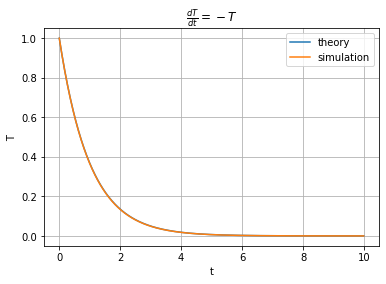

In [3]:
ode_simu = ODESimu(T0=1, t_end=10, dt=.01)
ode_theory = ODETheory(T0=1, t_end=10, dt=.01)
ode_theory.plot(label="theory")
ode_simu.plot(label="simulation")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()
plt.grid(True)
plt.title(r"$\frac{dT}{dt}=-T$")
plt.show()

#### Result of simulation

You can see the variation of temperature $T$ as shown in the figure above. We can see the simulated numerical solution is quite close to the exact solution.

## 2. PDE Simulation with a parallel program

### Problem statement

Write a parallel program to numerically solve the temperature distribution for a 2D system, i.e., a square plate with one side at a fixed temperature $T=20$°C and the other three sides fixed at $T=40$°C.

Heat equation:

$$
\begin{align}
\frac{\partial T}{\partial t}
&=\mathcal{K}\cdot div T\\
&=\mathcal{K}\left(\partial^2_x T+\partial^2_y T\right)
\end{align}
$$

### Numerical solution

First of all, approximate $\partial^2_x T \approx \frac{T(x-\Delta x,y;t)+T(x+\Delta x,y;t)-2T(x,y;t)}{{\Delta x}^2}$, similarly $\partial^2_y T \approx \frac{T(x,y+\Delta  y;t)+T(x,y+y-\Delta  y;t)-2T(x,y;t)}{{\Delta y}^2}$.

For simplification, let $\Delta y=\Delta x=h$, then

$$
div T(x,y;t) \approx \frac{T(x-h,y;t)+T(x+h,y;t)+T(x,y+h;t)+T(x,y-h;t)-4T(x,y;t)}{h^2}
$$

Denote the discrete Laplace operator $\mathcal L$ as 

$$
\mathcal L(T(x,y;t),h):=T(x-h,y;t)+T(x+h,y;t)+T(x,y+h;t)+T(x,y-h;t)-4T(x,y;t)
$$

Then,

$$
div T(x,y;t) \approx \frac{\mathcal L(T(x,y;t),h)}{h^2}
$$

With using Euler forward method, then

$$
\begin{align}
T(x,y;t+\Delta t)
&\approx T(x,y;t)+\mathcal{K}\cdot div T(x,y;t)\Delta t\\
&\approx T(x,y;t)+\mathcal{K}\cdot\mathcal L(T(x,y;t),h)\frac{\Delta t}{h^2}
\end{align}
$$


### Programming

With this forward iterated equation, we can program now.

In order to write a parrallel program with high efficiency, I use `numba` technique `@njit(parrallel=True)` to parallelize the code.

You can see the code in [PDESimu.py](PDESimu.py).

In [4]:
from PDESimu import *

### Simulation

#### Configure

We simulate the given square plate situation.

##### Border condition

We choose one side with fixed temperature $T=20$ and the other three sides with fixed temperature $T=40$.

##### Initial condition

Since the problem doesn't set the initial condition, for simplification, we choose $T(x,y;0)=20$ for everywhere on the plate except for the border.

##### Parameter

Set $\mathcal{K}=0.1,\Delta t=0.01,\Delta x=\Delta y=h=0.1,t_{end}=20$.

Set the length of plate $L_x=L_y=L$ depends on the parameter of scale $N$ by $L=Nh$. 

Set $N=50$ for this simulation.

##### Number of processes

Although the scale of this simulation is not large, but we also choose to use 4 processes to carry out this simulation in parallel manner.

In [5]:
def create_square_plate(N=50):
    T0 = 20*np.ones((N+2, N+2))
    T0[:, -1] = 40
    T0[0, :] = 40
    T0[-1, :] = 40
    T0[:, 0] = 20
    return T0

In [6]:
T0 = create_square_plate(N=50)
simu = PDESimu(T0, t_end=20, K=.1, dt=.01, h=.1, nprocess=4)
print(f"Target PDE simulation finished in {simu.used_time}s with {simu.nprocess} processes.")

Target PDE simulation finished in 0.7574097540000295s with 4 processes.


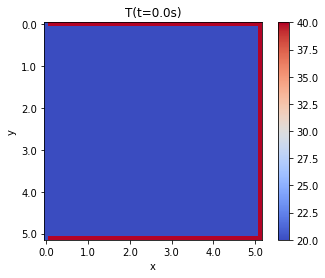

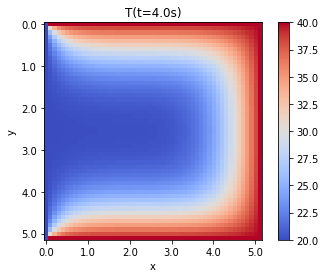

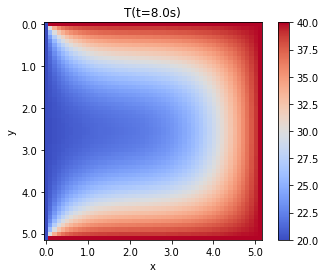

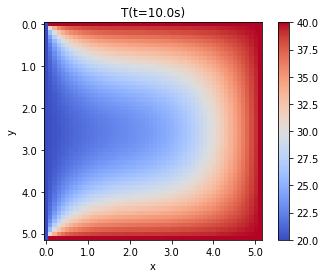

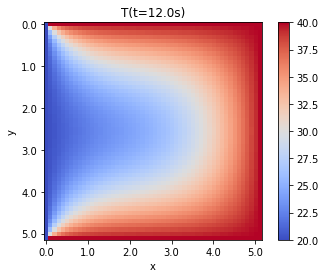

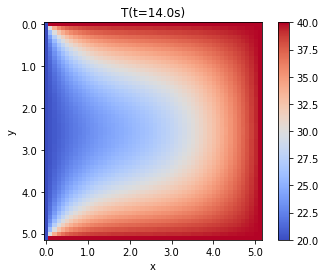

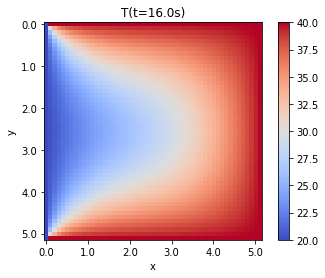

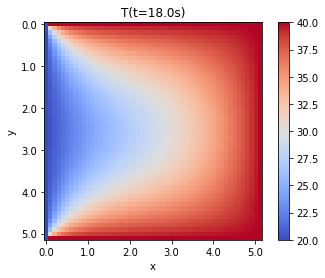

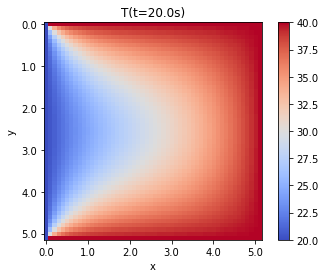

In [16]:
for f in simu.its[::200]:
    plt.cla()
    plt.title(f"T(t={simu.ts[f]:.1f}s)")
    plt.imshow(simu.Ts[f], cmap="coolwarm")
    plt.colorbar()
    ax=plt.gca()
    plt.xlabel("x")
    ax.set_xticklabels([x*simu.h for x in ax.get_xticks()])
    plt.ylabel("y")
    ax.set_yticklabels([y*simu.h for y in ax.get_yticks()])
    plt.show()

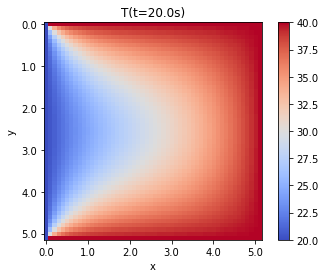

In [47]:
simu.anim(step=10)

> This animation can't be displayed in PDF, so you are recommended to view it in [`main.ipynb`](main.ipynb) or via https://algebra-fun.github.io/DDM-Coursework/MSDM5001/MiniProj/

#### Simulation Result

You can see the variation of temperature $T$ of the plate from above figure and animation, which can show the thermal diffusion progress.

## 3. Compare speedup and efficiency with different number of processes

### Problem statement

Change the number of processes involved in the above 2D calculation and evaluate speedup and efficiency.

### Metrics review

* Number of processes $P$
* Speedup $S(P)=\frac{T(1)}{T(P)}$
* Efficiency $E(P)=\frac {S(P)}P\leq1$

In [4]:
def perf_simu(N,P,trails=3,t_end=10):
    TPs = []
    for i in range(trails):
        T0 = create_square_plate(N=N)
        simu = PDESimu(T0, t_end=t_end, K=.1, dt=.01, h=.1, nprocess=P)
        TPs.append(simu.used_time)
    return TPs

### Experiment 1

Check running time on different Scale $N=100,200,500,1000$ of plate with $P=1,2,4$ 

In [16]:
Ns=(100,200,500,1000)
Ps=(1,2,4)
Ts=[[np.median(perf_simu(N,P,trails=5,t_end=1)) for N in Ns] for P in Ps]

In [17]:
for T,P in zip(Ts,Ps):
    plt.plot(Ns,T,marker="o",label=f"P={P}")
plt.xlabel("N")
plt.ylabel("T")
plt.legend()
plt.grid(True)
plt.show()

From this figure, we can see when the number of processes increase, the running time decrease.

### Experiment 2

Check performance on same Scale $N=500$ of plate with $P=1,2,4,8$.

First of all, let check the device info of cpu.

In [5]:
os.cpu_count()

8

Although it return 8 as the number of cpu, actually this device only has 4 core and each core can host 2 logical processes, so the 8 is the number of logic processors.

In [25]:
Ps=np.array([1,2,4,8])
N=500
Ts=np.array([np.median(perf_simu(N,P,trails=10)) for P in Ps])
Ss=Ts[0]/Ts
Es=Ss/Ps
perfs=pd.DataFrame({"P":Ps,"T":Ts,"S":Ss,"E":Es})
perfs

P         T         S         E
0  1  0.695843  1.000000  1.000000
1  2  0.358653  1.940158  0.970079
2  4  0.187390  3.713336  0.928334
3  8  0.229766  3.028481  0.378560

From this table, we can see speedup $S$ increase and efficiency $E$ decrease as we expected when the number of processes $P$ increase from 1 to 2 to 4. But the result is unexpected when $P=8$, actually it's easy to explain this phenomenon since the number of real processors is only 4, so when $P>4$ the device can't handle more processes simultaneously and more processes means more overhead time consumption.